# Entrainement du modèle de reconnaissance de symboles mathématiques

In [1]:
# La classe Image permet de charger et d'afficher des images dans un notebook Jupyter
from IPython.display import Image

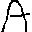

In [2]:
# Permet d'afficher l'image
Image("/kaggle/input/hasyv2/hasy-data/v2-00010.png")

In [3]:
# csv : une bibliothèque pour la manipulation de fichiers CSV (Comma-Separated Values), souvent utilisée pour stocker des données tabulaires.
# PIL : une bibliothèque pour la manipulation d'images en Python.
# keras.preprocessing.image : une bibliothèque pour le prétraitement d'images avant l'apprentissage automatique.
import csv
from PIL import Image as pil_image
import keras.preprocessing.image

In [4]:
# On lit le fichier csv et on ne garde que les 50 premières images de chaque caractère, car sinon ça sera trop long pour exécuter et ça utilisera trop de ram
# On utilise keras.preprocessing.image.image_utils.img_to_array au lieu de keras.preprocessing.image.img_to_array, car on n'a pas la même version que sur le livre
# On stock ensuite chaque image dans un tableau avec des valeurs entre 0 et 1 
imgs = []
classes = {}
with open('/kaggle/input/hasyv2/hasy-data-labels.csv') as csvfile:
    csvreader = csv.reader(csvfile)
    i = 0
    for row in csvreader:
        if i > 0:
            img_class = row[2]
            if img_class not in classes:
                classes[img_class] = 0
            if classes[img_class] < 50:
                img = keras.preprocessing.image.image_utils.img_to_array(pil_image.open("/kaggle/input/hasyv2/" + row[0]))
                img /= 255.0
                imgs.append((row[0], img_class, img))
                classes[img_class] += 1
        i += 1

classes = list(classes.keys())

In [5]:
imgs[0]

('hasy-data/v2-00000.png',
 'A',
 array([[[1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.],
         ...,
         [1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.]],
 
        [[1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.],
         ...,
         [1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.]],
 
        [[1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.],
         ...,
         [1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.]],
 
        ...,
 
        [[1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.],
         ...,
         [1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.]],
 
        [[1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.],
         ...,
         [1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.]],
 
        [[1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.],
         ...,
         [1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.]]], dtype=float32))

In [6]:
len(imgs)

18450

In [7]:
import random

random.shuffle(imgs)
split_idx = int(0.8*len(imgs))
train = imgs[:split_idx]
test = imgs[split_idx:]

In [8]:
import numpy as np

train_input = np.asarray(list(map(lambda row: row[2], train)))
test_input = np.asarray(list(map(lambda row: row[2], test)))

train_output = np.asarray(list(map(lambda row: row[1], train)))
test_output = np.asarray(list(map(lambda row: row[1], test)))

In [9]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

In [10]:
# convert class names into one-hot encoding

# first, convert class names into integers
label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(classes)

# then convert integers into one-hot encoding
onehot_encoder = OneHotEncoder(sparse=False)
integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
onehot_encoder.fit(integer_encoded)

# convert train and test output to one-hot
train_output_int = label_encoder.transform(train_output)
train_output = onehot_encoder.transform(train_output_int.reshape(len(train_output_int), 1))
test_output_int = label_encoder.transform(test_output)
test_output = onehot_encoder.transform(test_output_int.reshape(len(test_output_int), 1))

num_classes = len(label_encoder.classes_)
print("Number of classes: %d" % num_classes)

Number of classes: 369


In [11]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D

In [12]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(3,3), activation="relu", input_shape=np.shape(train_input[0])))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(32, (3, 3), activation="relu"))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Flatten())
model.add(Dense(1024, activation="tanh"))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation="softmax"))

model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 15, 15, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 13, 13, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 6, 6, 32)         0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 1152)              0         
                                                                 
 dense (Dense)               (None, 1024)              1

In [13]:
import keras.callbacks

tensorboard = keras.callbacks.TensorBoard(log_dir="./logs/mnist-style")

In [14]:
model.fit(train_input, train_output, batch_size=32, epochs=10, verbose=2, validation_split=0.2, callbacks=[tensorboard])

Epoch 1/10
369/369 - 13s - loss: 4.1768 - accuracy: 0.1854 - val_loss: 2.3881 - val_accuracy: 0.4329 - 13s/epoch - 35ms/step
Epoch 2/10
369/369 - 12s - loss: 2.0572 - accuracy: 0.4912 - val_loss: 1.8811 - val_accuracy: 0.5288 - 12s/epoch - 31ms/step
Epoch 3/10
369/369 - 11s - loss: 1.5129 - accuracy: 0.5928 - val_loss: 1.7340 - val_accuracy: 0.5552 - 11s/epoch - 31ms/step
Epoch 4/10
369/369 - 11s - loss: 1.2093 - accuracy: 0.6568 - val_loss: 1.6562 - val_accuracy: 0.5833 - 11s/epoch - 30ms/step
Epoch 5/10
369/369 - 11s - loss: 1.0009 - accuracy: 0.7116 - val_loss: 1.6988 - val_accuracy: 0.5728 - 11s/epoch - 30ms/step
Epoch 6/10
369/369 - 11s - loss: 0.8442 - accuracy: 0.7496 - val_loss: 1.7616 - val_accuracy: 0.5728 - 11s/epoch - 31ms/step
Epoch 7/10
369/369 - 11s - loss: 0.7370 - accuracy: 0.7743 - val_loss: 1.8335 - val_accuracy: 0.5732 - 11s/epoch - 30ms/step
Epoch 8/10
369/369 - 11s - loss: 0.6134 - accuracy: 0.8056 - val_loss: 1.8843 - val_accuracy: 0.5745 - 11s/epoch - 30ms/step


In [15]:
import time

results = []

for conv2d_count in [1,2]:
    for dense_size in [128,256,512]:
        for dropout in [0.0, 0.25, 0.50, 0.75]:
            model = Sequential()
            
            for i in range(conv2d_count):
                if i == 0:
                    model.add(Conv2D(32, kernel_size=(3,3), activation="relu", input_shape=np.shape(train_input[0])))
                else:
                    model.add(Conv2D(32, kernel_size=(3,3), activation="relu"))
                model.add(MaxPooling2D(pool_size=(2,2)))
            model.add(Flatten())
            model.add(Dense(dense_size, activation="tanh"))
            
            if dropout > 0.0:
                model.add(Dropout(dropout))
            model.add(Dense(num_classes, activation="softmax"))
            
            model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
            
            log_dir = "./logs/conv2d_%d-dense_%d-dropout_%.2f" % (conv2d_count, dense_size, dropout)
            tensorboard = keras.callbacks.TensorBoard(log_dir=log_dir)
            
            start = time.time()
            model.fit(train_input, train_output, batch_size=32, epochs=10, verbose=0, validation_split=0.2, callbacks=[tensorboard])
            score = model.evaluate(test_input, test_output, verbose=2)
            end = time.time()
            
            print("Conv2D count: %d, Dense size: %d, Dropout: %.2f - Loss: %.2f, Accuracy: %.2f, Time: %d sec" % (conv2d_count, dense_size, dropout, score[0], score[1], end - start))

116/116 - 1s - loss: 1.6770 - accuracy: 0.5778 - 709ms/epoch - 6ms/step
Conv2D count: 1, Dense size: 128, Dropout: 0.00 - Loss: 1.68, Accuracy: 0.58, Time: 68 sec
116/116 - 1s - loss: 1.5497 - accuracy: 0.5938 - 662ms/epoch - 6ms/step
Conv2D count: 1, Dense size: 128, Dropout: 0.25 - Loss: 1.55, Accuracy: 0.59, Time: 68 sec
116/116 - 1s - loss: 1.5557 - accuracy: 0.5873 - 667ms/epoch - 6ms/step
Conv2D count: 1, Dense size: 128, Dropout: 0.50 - Loss: 1.56, Accuracy: 0.59, Time: 83 sec
116/116 - 1s - loss: 1.5968 - accuracy: 0.5976 - 673ms/epoch - 6ms/step
Conv2D count: 1, Dense size: 128, Dropout: 0.75 - Loss: 1.60, Accuracy: 0.60, Time: 83 sec
116/116 - 1s - loss: 1.6406 - accuracy: 0.5911 - 814ms/epoch - 7ms/step
Conv2D count: 1, Dense size: 256, Dropout: 0.00 - Loss: 1.64, Accuracy: 0.59, Time: 91 sec
116/116 - 1s - loss: 1.6142 - accuracy: 0.5913 - 816ms/epoch - 7ms/step
Conv2D count: 1, Dense size: 256, Dropout: 0.25 - Loss: 1.61, Accuracy: 0.59, Time: 94 sec
116/116 - 1s - loss: 1

In [16]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(3,3), activation="relu", input_shape=np.shape(train_input[0])))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(32, (3,3), activation="relu"))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Flatten())
model.add(Dense(128, activation="tanh"))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation="softmax"))
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
print(model.summary())

# join train and test data so we train the network on all data we have available to us
model.fit(np.concatenate((train_input, test_input)), np.concatenate((train_output, test_output)), batch_size=32, epochs=10, verbose=2)

# save the trained model
model.save("mathsymbols.model")

# save label encoder (to reverse one-hot encoding)
np.save("classes.npy", label_encoder.classes_)

Model: "sequential_25"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_38 (Conv2D)          (None, 30, 30, 32)        896       
                                                                 
 max_pooling2d_38 (MaxPoolin  (None, 15, 15, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_39 (Conv2D)          (None, 13, 13, 32)        9248      
                                                                 
 max_pooling2d_39 (MaxPoolin  (None, 6, 6, 32)         0         
 g2D)                                                            
                                                                 
 flatten_25 (Flatten)        (None, 1152)              0         
                                                                 
 dense_50 (Dense)            (None, 128)             

# Utilisation du modèle de reconnaissance de symboles mathématiques

In [17]:
# Load the pre-trained model and predict the math symbol for an arbitrary image; the code below could be placed in a separate file

import keras.models

model2 = keras.models.load_model("mathsymbols.model")
print(model2.summary())

# restore the class name to integer encoder
label_encoder2 = LabelEncoder()
label_encoder2.classes_ = np.load("classes.npy")

def predict(img_path):
    newimg = keras.preprocessing.image.image_utils.img_to_array(pil_image.open(img_path))
    newimg /= 255.0
    
    # do the prediction
    prediction = model2.predict(newimg.reshape(1, 32, 32, 3))
    
    # figure out whitch output neuron had the highest score, and reverse the one-hot encoding
    inverted = label_encoder2.inverse_transform([np.argmax(prediction)]) # argmax finds highest-scoring output
    print("Prediction: %s, confidence: %.2f" % (inverted[0], np.max(prediction)))

Model: "sequential_25"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_38 (Conv2D)          (None, 30, 30, 32)        896       
                                                                 
 max_pooling2d_38 (MaxPoolin  (None, 15, 15, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_39 (Conv2D)          (None, 13, 13, 32)        9248      
                                                                 
 max_pooling2d_39 (MaxPoolin  (None, 6, 6, 32)         0         
 g2D)                                                            
                                                                 
 flatten_25 (Flatten)        (None, 1152)              0         
                                                                 
 dense_50 (Dense)            (None, 128)             

In [18]:
predict("/kaggle/input/hasyv2/hasy-data/v2-00010.png")

1/1 [==============================] - 0s 115ms/step
Prediction: A, confidence: 0.26


In [19]:
predict("/kaggle/input/hasyv2/hasy-data/v2-00500.png")

1/1 [==============================] - 0s 22ms/step
Prediction: \pi, confidence: 0.36


In [20]:
predict("/kaggle/input/hasyv2/hasy-data/v2-00700.png")

1/1 [==============================] - 0s 22ms/step
Prediction: \alpha, confidence: 0.48
